# Lesson 3

### MLP aproach: A Neural Probabilistic Language Model

###### Paper of the 2003<br>17000 words in a 30-dimensional space

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("makemore/names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # Roling window -> crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Nel paper viene compressa una dimensione di input di 17000 parole in uno spazio di 30 parametri.
Qui il nostro input sono i caratteri (27) e restringiamoli anche qui, diciamo in 2 parametri

In [9]:
C = torch.randn((27, 2))

In [10]:
C

tensor([[ 0.4090,  0.4289],
        [ 0.0661, -0.7453],
        [ 1.1181,  0.4979],
        [-0.6149, -0.6365],
        [ 2.6556,  0.5934],
        [ 0.7762,  1.6402],
        [ 0.5352,  0.5680],
        [ 0.3897, -0.2653],
        [-0.1092, -1.0331],
        [ 0.7499, -0.3677],
        [-0.1738, -0.2647],
        [ 0.1689,  1.2740],
        [-0.1351, -1.4086],
        [-1.0164, -0.5782],
        [ 1.9228, -1.7054],
        [ 0.3901,  0.1830],
        [-1.1927, -0.0765],
        [-0.6083,  1.0541],
        [ 0.4656,  0.5196],
        [-0.5186,  0.6854],
        [-1.0423, -0.0344],
        [-1.3706,  0.8421],
        [-0.5571, -0.3252],
        [ 0.5243, -0.5320],
        [ 0.3230,  0.9129],
        [-0.9701,  0.7746],
        [-0.1179, -0.5457]])

In [11]:
C[5]

tensor([0.7762, 1.6402])

In [12]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.7762, 1.6402])

In [13]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Bisogna trasformare l'input emb da (32,3,2) in (32,6) per poter fare la moltiplicazione matriciale: emb @ W1

In [15]:
# 1. Way
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [16]:
# 2. Alternative way 
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

http://blog.ezyang.com/2019/05/pytorch-internals/

In [17]:
# 3. More efficient way in Python
# Reason at: http://blog.ezyang.com/2019/05/pytorch-internals/
a = torch.arange(18)

In [18]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [19]:
emb.view(32,6)

tensor([[ 0.4090,  0.4289,  0.4090,  0.4289,  0.4090,  0.4289],
        [ 0.4090,  0.4289,  0.4090,  0.4289,  0.7762,  1.6402],
        [ 0.4090,  0.4289,  0.7762,  1.6402, -1.0164, -0.5782],
        [ 0.7762,  1.6402, -1.0164, -0.5782, -1.0164, -0.5782],
        [-1.0164, -0.5782, -1.0164, -0.5782,  0.0661, -0.7453],
        [ 0.4090,  0.4289,  0.4090,  0.4289,  0.4090,  0.4289],
        [ 0.4090,  0.4289,  0.4090,  0.4289,  0.3901,  0.1830],
        [ 0.4090,  0.4289,  0.3901,  0.1830, -0.1351, -1.4086],
        [ 0.3901,  0.1830, -0.1351, -1.4086,  0.7499, -0.3677],
        [-0.1351, -1.4086,  0.7499, -0.3677, -0.5571, -0.3252],
        [ 0.7499, -0.3677, -0.5571, -0.3252,  0.7499, -0.3677],
        [-0.5571, -0.3252,  0.7499, -0.3677,  0.0661, -0.7453],
        [ 0.4090,  0.4289,  0.4090,  0.4289,  0.4090,  0.4289],
        [ 0.4090,  0.4289,  0.4090,  0.4289,  0.0661, -0.7453],
        [ 0.4090,  0.4289,  0.0661, -0.7453, -0.5571, -0.3252],
        [ 0.0661, -0.7453, -0.5571, -0.3

In [20]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

In [21]:
h.shape

torch.Size([32, 100])

In [22]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2

In [24]:
logits.shape

torch.Size([32, 27])

In [25]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [26]:
prob.shape

torch.Size([32, 27])

In [27]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(21.0731)

## Code reorganized

In [28]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # Roling window -> crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [29]:
X.shape, Y.shape # datasets

(torch.Size([228146, 3]), torch.Size([228146]))

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [32]:
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

Esiste la cross entropy function di torch

In [ ]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(10):
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    

8.329231262207031
8.144330024719238
7.966795921325684
7.796455383300781
7.633191108703613
7.476912975311279
7.327526569366455
7.184890270233154
7.048797130584717
6.9189581871032715


In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([ 8.2985,  9.8879, 18.4876,  ..., 11.3038, 13.8946, 12.4195],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9,  8,  9,  ..., 15, 11, 17]))

Siccome l'esecuzione è 'lenta', ne approfitta per introdurre il minibatch

In [ ]:
# Random i campioni:
torch.randint(0, X.shape[0], (32,))

tensor([ 65740, 190895,  61533, 168223, 221694,  14791,  27034,   9066, 178256,
        131645,  76638,  49612,  46517,  34526, 106444,  77777, 191745,  49122,
        131792,  15840, 132166, 171074,  82528, 108255,   7112, 101162,  21854,
         27735,  78073,  75767,   4860, 210291])

In [ ]:
for _ in range(100000):

    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]] # grab only those rows (32,3,2) and not (220000, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    

2.907209873199463
2.652191400527954
2.60135555267334
2.835146903991699
2.772749185562134
2.9241414070129395
2.521439552307129
2.6010255813598633
2.8675384521484375
2.4550390243530273
2.5501604080200195
3.063462972640991
2.530407190322876
2.736997604370117
2.6975560188293457
2.657259702682495
2.7997889518737793
2.6137986183166504
2.7079761028289795
2.841482639312744
2.6221981048583984
2.726254463195801
2.635676145553589
2.8312530517578125
2.8461408615112305
2.2289438247680664
2.6222219467163086
2.7145349979400635
2.8263771533966064
2.5108330249786377
2.5333480834960938
2.5723204612731934
2.5175423622131348
2.7974843978881836
2.5068857669830322
3.077362298965454
2.509220600128174
2.5430376529693604
2.709956645965576
2.661627769470215
2.7821245193481445
2.640842914581299
3.3453757762908936
2.96553111076355
2.849560499191284
2.7592127323150635
2.978875160217285
2.4884488582611084
2.372861385345459
2.904230833053589
2.2621002197265625
3.1366093158721924
2.724616050720215
2.5338857173919678


## Learning rate optimization

In [38]:
# -3 and 0 because are the exponents of 0.001 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [ ]:
lri = []
lossi = []

for i in range(1000):

    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]] # grab only those rows (32,3,2) and not (220000, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    

18.952587127685547
19.360857009887695
21.383703231811523
17.537965774536133
20.436960220336914
20.07642936706543
19.04775047302246
16.163057327270508
18.801328659057617
19.482683181762695
18.78690528869629
20.84005355834961
18.916656494140625
19.293806076049805
18.67521858215332
18.83353614807129
21.478654861450195
18.737089157104492
18.47662353515625
18.185203552246094
19.79081153869629
21.22309112548828
18.933082580566406
19.05788230895996
21.250751495361328
18.80904197692871
20.14730453491211
19.418289184570312
20.0323543548584
20.035741806030273
20.768081665039062
21.23503303527832
18.214977264404297
18.064064025878906
22.89382553100586
18.93683433532715
17.29763412475586
16.310977935791016
19.44318962097168
18.898344039916992
18.274700164794922
17.443599700927734
21.39097785949707
17.915538787841797
17.542383193969727
17.30023193359375
19.339887619018555
16.41575050354004
18.06808853149414
18.049901962280273
18.076297760009766
16.812299728393555
19.904281616210938
17.3349285125732

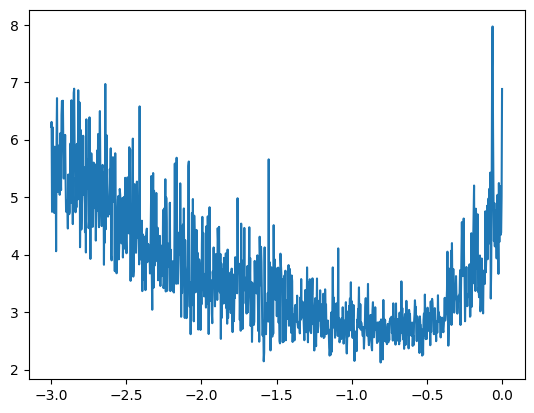

In [ ]:
plt.plot(lri, lossi)
plt.show()

0.1 è un ottimo Learning rate

# Training set, Validation set, Test set (80, 10, 10)

In [34]:
def build_dataset(words):

    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Roling window -> crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [36]:
for p in parameters:
    p.requires_grad = True

In [39]:
lri = []
lossi = []

for i in range(10000):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]] # grab only those rows (32,3,2) and not (220000, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

IndexError: index 1000 is out of bounds for dimension 0 with size 1000